In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cluster import KMeans
import matplotlib.cm as cm
from sklearn.metrics import (
    r2_score, accuracy_score, precision_score, recall_score, confusion_matrix, 
    classification_report, silhouette_score, silhouette_samples
)

In [51]:
df = pd.read_csv('../data/unprocessed/unprocessed.csv')

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3164 entries, 0 to 3163
Data columns (total 12 columns):
Unnamed: 0     3140 non-null float64
PP             3164 non-null object
C              3164 non-null object
timestamp      3164 non-null object
HR             1514 non-null object
RMSSD          1514 non-null object
SCL            2602 non-null object
date           3164 non-null object
subject        3164 non-null object
label          3164 non-null object
Condition      3164 non-null object
ElapsedTime    3164 non-null object
dtypes: float64(1), object(11)
memory usage: 296.8+ KB


In [53]:
# Labels: 'rest', 'no stress', 'time pressure', 'interruption'

In [54]:
df.describe()

,Unnamed: 0
count,3140.000000
mean,1569.500000
std,906.584249
min,0.000000
25%,784.750000
50%,1569.500000
75%,2354.250000
max,3139.000000


In [55]:
df.head()

,Unnamed: 0,PP,C,timestamp,HR,RMSSD,SCL,date,subject,label,Condition,ElapsedTime
0,0.0,PP1,1,20120918T131600000,NaN,NaN,80.239727,2012-09-18 13:16:00,p1,rest,R,0
1,1.0,PP1,1,20120918T131700000,61,0.06142,77.365127,2012-09-18 13:17:00,p1,rest,R,1
2,2.0,PP1,1,20120918T131800000,64,0.049663,77.359559,2012-09-18 13:18:00,p1,rest,R,2
3,3.0,PP1,1,20120918T131900000,60,0.052487,76.728772,2012-09-18 13:19:00,p1,rest,R,3
4,4.0,PP1,1,20120918T132000000,61,0.051189,76.512877,2012-09-18 13:20:00,p1,rest,R,4


In [56]:
df.drop(columns=["Unnamed: 0", 'PP', 'C', 'timestamp'], inplace=True)

In [57]:
df.head()

,HR,RMSSD,SCL,date,subject,label,Condition,ElapsedTime
0,NaN,NaN,80.239727,2012-09-18 13:16:00,p1,rest,R,0
1,61,0.06142,77.365127,2012-09-18 13:17:00,p1,rest,R,1
2,64,0.049663,77.359559,2012-09-18 13:18:00,p1,rest,R,2
3,60,0.052487,76.728772,2012-09-18 13:19:00,p1,rest,R,3
4,61,0.051189,76.512877,2012-09-18 13:20:00,p1,rest,R,4


In [58]:
break_idxs = []
for idx, d in enumerate(df['date']):
    try:
        pd.to_datetime(d)
    except:
        print("PROBLEM")
        print(idx)
        print('----')
        break_idxs.append(idx)

PROBLEM
129
----
PROBLEM
251
----
PROBLEM
380
----
PROBLEM
509
----
PROBLEM
635
----
PROBLEM
762
----
PROBLEM
893
----
PROBLEM
1010
----
PROBLEM
1133
----
PROBLEM
1262
----
PROBLEM
1390
----
PROBLEM
1520
----
PROBLEM
1647
----
PROBLEM
1777
----
PROBLEM
1899
----
PROBLEM
2029
----
PROBLEM
2159
----
PROBLEM
2279
----
PROBLEM
2410
----
PROBLEM
2540
----
PROBLEM
2647
----
PROBLEM
2774
----
PROBLEM
2904
----
PROBLEM
3035
----


In [59]:
df.loc[3035]

HR                      HR
RMSSD                RMSSD
SCL                    SCL
date                  date
subject            subject
label                label
Condition        Condition
ElapsedTime    ElapsedTime
Name: 3035, dtype: object

In [60]:
df = df.drop(break_idxs)

In [61]:
df['date'] = pd.to_datetime(df['date'])

In [62]:
df.head()

,HR,RMSSD,SCL,date,subject,label,Condition,ElapsedTime
0,NaN,NaN,80.239727,2012-09-18 13:16:00,p1,rest,R,0
1,61,0.06142,77.365127,2012-09-18 13:17:00,p1,rest,R,1
2,64,0.049663,77.359559,2012-09-18 13:18:00,p1,rest,R,2
3,60,0.052487,76.728772,2012-09-18 13:19:00,p1,rest,R,3
4,61,0.051189,76.512877,2012-09-18 13:20:00,p1,rest,R,4


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3140 entries, 0 to 3163
Data columns (total 8 columns):
HR             1490 non-null object
RMSSD          1490 non-null object
SCL            2578 non-null object
date           3140 non-null datetime64[ns]
subject        3140 non-null object
label          3140 non-null object
Condition      3140 non-null object
ElapsedTime    3140 non-null object
dtypes: datetime64[ns](1), object(7)
memory usage: 220.8+ KB


In [78]:
df = df.set_index(df['date'])

In [79]:
df['HR'] = df['HR'].astype('int64')
df['RMSSD'] = df['RMSSD'].astype('float64')

In [80]:
# RR is the peak in a heartbeat
# RR interval (RRI) is the distance between peaks in milliseconds between beats from an ECG
# RMSDD is the square root of the mean distance between RR for a period of time
# RMSDD is used as HRV calculation based on one minute intervals
# SDNN is the standard deviaiton of all the RR intervals

In [81]:
178 / 60

2.966666666666667

In [82]:
# 2.97 hours of data per participant

In [83]:
# Conditions are R: rest, N: no stress, T: time pressure, I: interruption 
# No stress - Allowed to work for a maximum 45 minutes but they don't know the duration 
# Time Pressure - Time limit of 2/3 to complete task based on duration in no stress
# Interruption - Received 8 emails in the middle of the assigned task 
# Relax - Not working on a task

In [84]:
df.head()

,HR,RMSSD,SCL,date,subject,label,Condition,ElapsedTime
date,,,,,,,,
2012-09-18 13:17:00,61,0.061420,77.365127,2012-09-18 13:17:00,p1,rest,R,1
2012-09-18 13:18:00,64,0.049663,77.359559,2012-09-18 13:18:00,p1,rest,R,2
2012-09-18 13:19:00,60,0.052487,76.728772,2012-09-18 13:19:00,p1,rest,R,3
2012-09-18 13:20:00,61,0.051189,76.512877,2012-09-18 13:20:00,p1,rest,R,4
2012-09-18 13:21:00,65,0.037098,76.873877,2012-09-18 13:21:00,p1,rest,R,5


In [85]:
subjects = df['subject'].unique()

In [86]:
subjects = subjects[(subjects != ['p8'])]
subjects = subjects[(subjects != ['p11'])]
subjects = subjects[(subjects != ['p15'])]

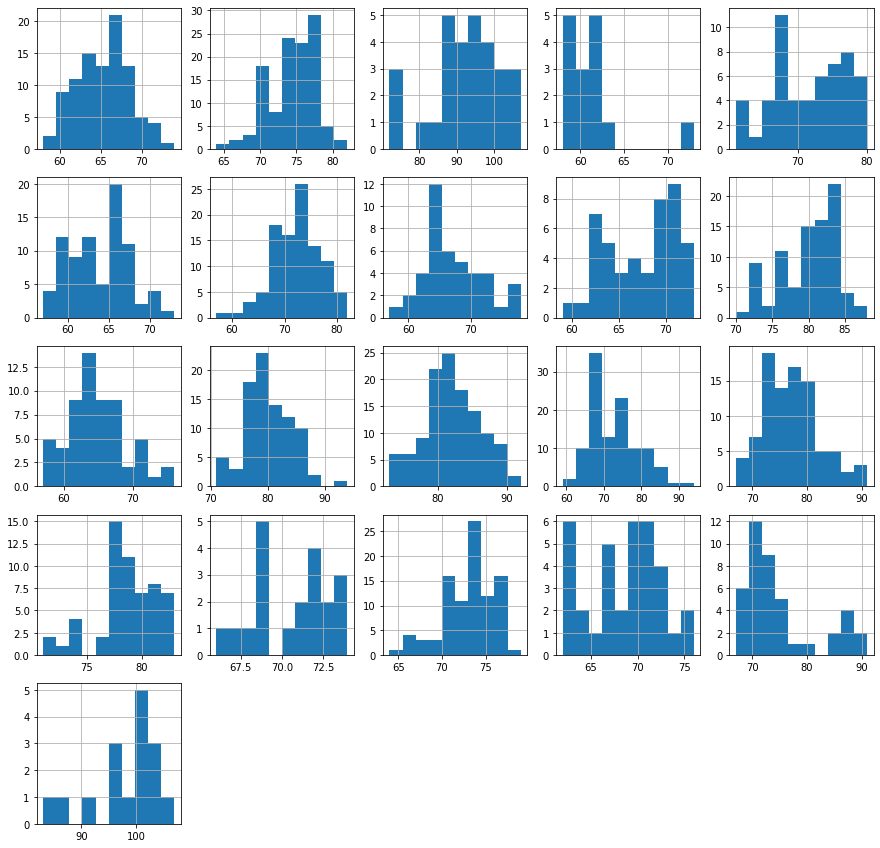

In [129]:
fig, axs = plt.subplots(5, 5, figsize=(15, 15))
for ax, subject in zip(axs.flatten(), subjects):
    df[df['subject'] == (subject)]['HR'].hist(ax=ax)
fig.delaxes(axs[-1, -1])
fig.delaxes(axs[-1, -2])
fig.delaxes(axs[-1, -3])
fig.delaxes(axs[-1, -4])

In [88]:
df.head()

,HR,RMSSD,SCL,date,subject,label,Condition,ElapsedTime
date,,,,,,,,
2012-09-18 13:17:00,61,0.061420,77.365127,2012-09-18 13:17:00,p1,rest,R,1
2012-09-18 13:18:00,64,0.049663,77.359559,2012-09-18 13:18:00,p1,rest,R,2
2012-09-18 13:19:00,60,0.052487,76.728772,2012-09-18 13:19:00,p1,rest,R,3
2012-09-18 13:20:00,61,0.051189,76.512877,2012-09-18 13:20:00,p1,rest,R,4
2012-09-18 13:21:00,65,0.037098,76.873877,2012-09-18 13:21:00,p1,rest,R,5


In [89]:
df = df.dropna()

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1437 entries, 2012-09-18 13:17:00 to 2012-11-07 14:39:00
Data columns (total 8 columns):
HR             1437 non-null int64
RMSSD          1437 non-null float64
SCL            1437 non-null object
date           1437 non-null datetime64[ns]
subject        1437 non-null object
label          1437 non-null object
Condition      1437 non-null object
ElapsedTime    1437 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 101.0+ KB


In [132]:
df['label'].unique()

array(['rest', 'no stress', 'time pressure', 'interruption'], dtype=object)

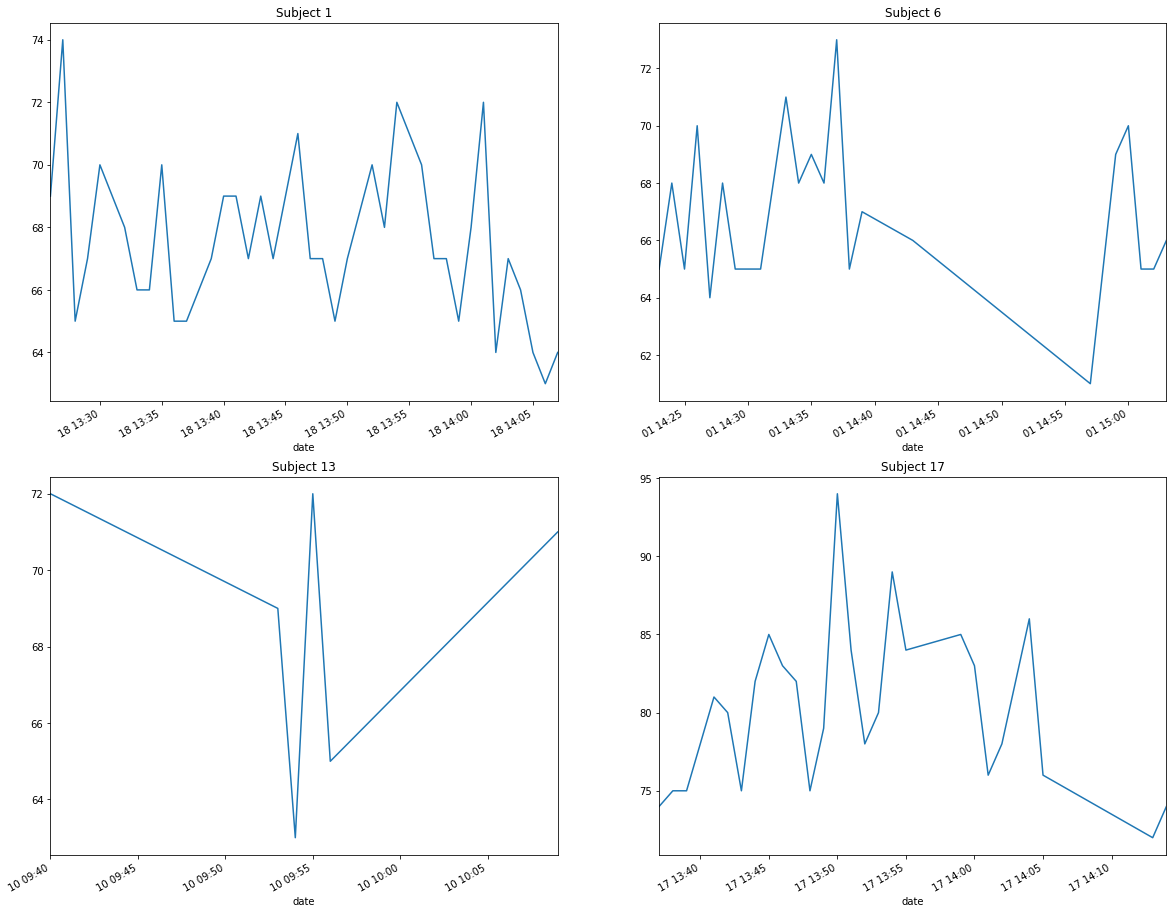

In [160]:
fig, axs = plt.subplots(2, 2, figsize=(20, 17))
for ax, subject in zip(axs.flatten(), ['1', '6', '13', '17']):
    try:
        ax.set_title(f'Subject {subject}')
        df[(df['subject'] == ('p' + subject)) & (df['label'] == 'no stress')]['HR'].plot(ax=ax)
    except:
        print(subject)
        continue

In [182]:
df[(df['subject'] == 'p1') & (df['label'] == 'no stress')]['HR'].mean()

67.525

In [180]:
df[(df['subject'] == 'p1') & (df['label'] == 'interruption')]['HR'].mean()

63.26923076923077

In [181]:
df[(df['subject'] == 'p1') & (df['label'] == 'time pressure')]['HR'].mean()

64.52173913043478

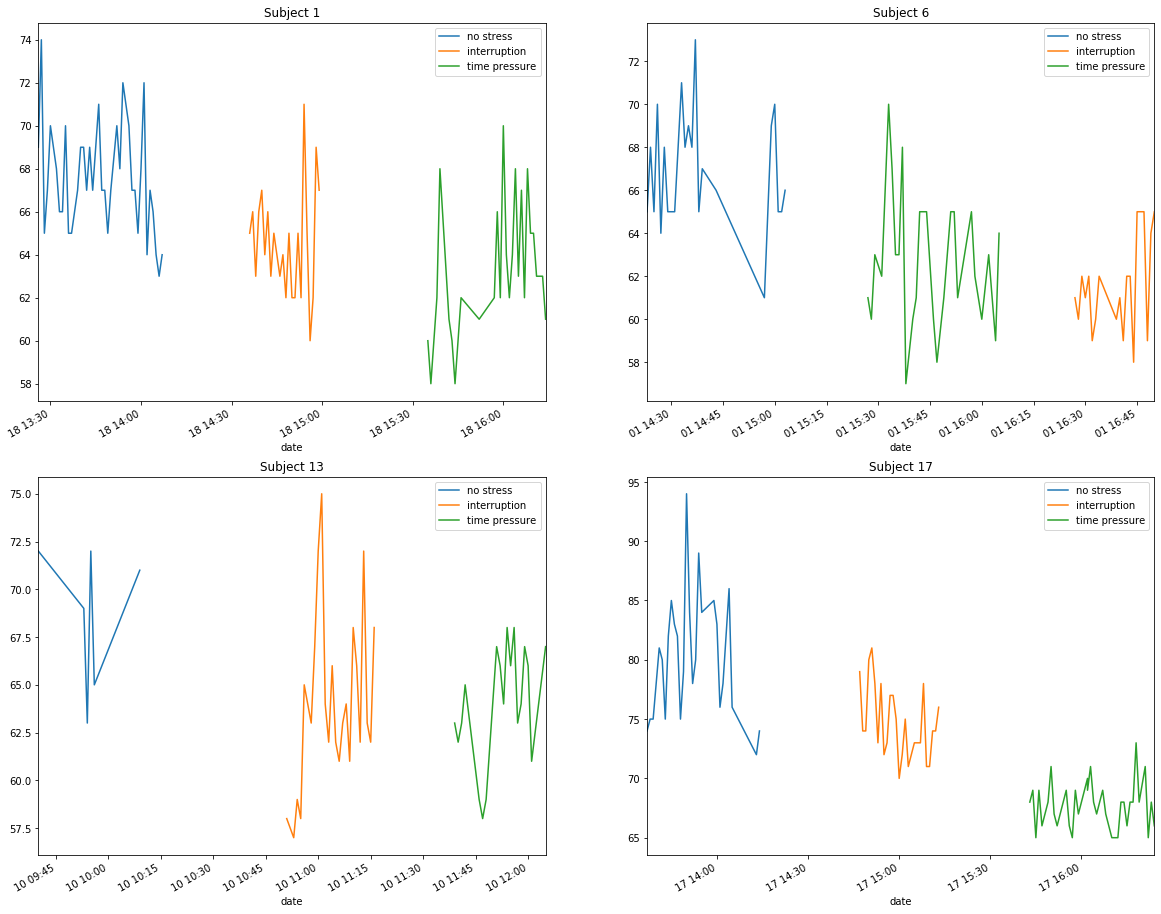

In [168]:
fig, axs = plt.subplots(2, 2, figsize=(20, 17))
for ax, subject in zip(axs.flatten(), ['1', '6', '13', '17']):
    try:
        ax.set_title(f'Subject {subject}')
        df[(df['subject'] == ('p' + subject)) & (df['label'] == 'no stress')]['HR'].plot(ax=ax, label='no stress')
        df[(df['subject'] == ('p' + subject)) & (df['label'] == 'interruption')]['HR'].plot(ax=ax, label='interruption')
        df[(df['subject'] == ('p' + subject)) & (df['label'] == 'time pressure')]['HR'].plot(ax=ax, label='time pressure')
        ax.legend()
    except:
        print(subject)
        continue

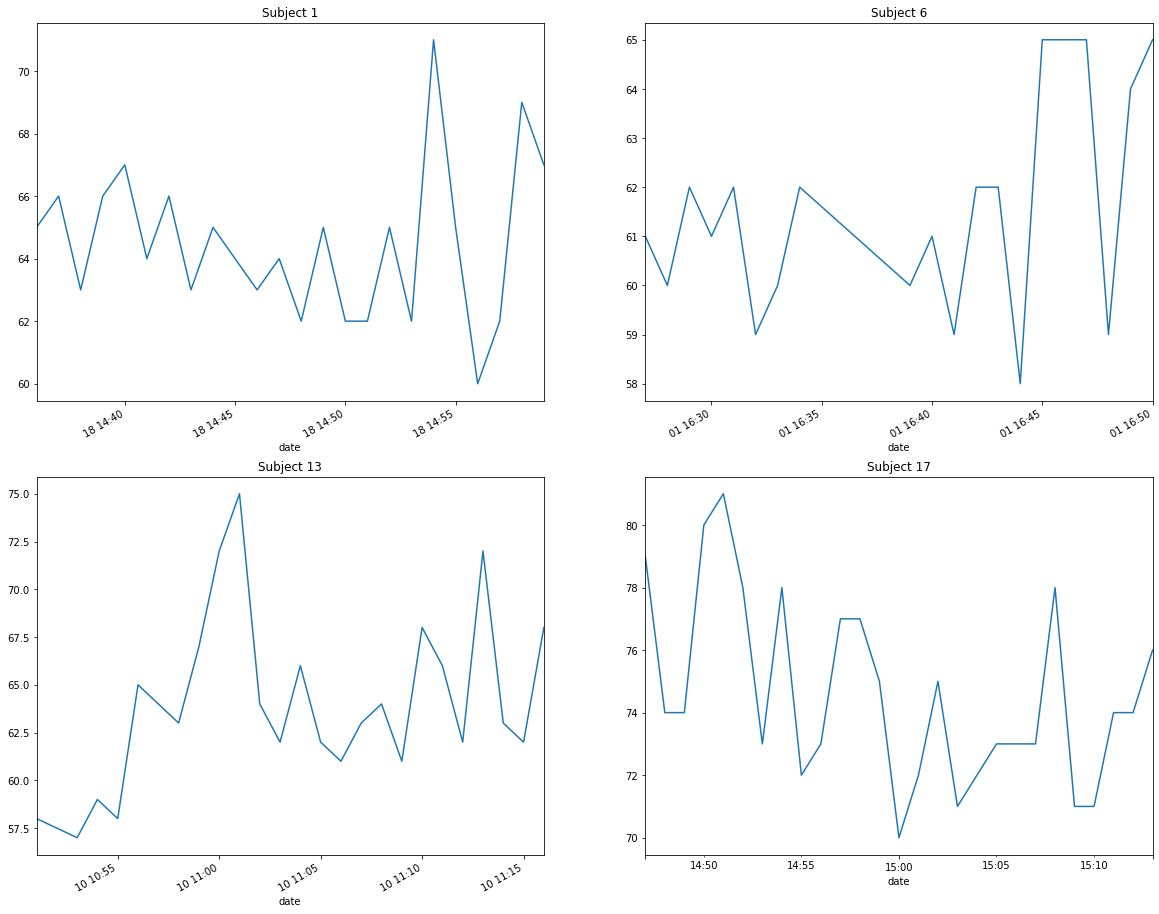

In [163]:
fig, axs = plt.subplots(2, 2, figsize=(20, 17))
for ax, subject in zip(axs.flatten(), ['1', '6', '13', '17']):
    try:
        ax.set_title(f'Subject {subject}')
        df[(df['subject'] == ('p' + subject)) & (df['label'] == 'time pressure')]['HR'].plot(ax=ax)
    except:
        print(subject)
        continue

In [ ]:
# fig, ax = plt.subplots(figsize=(15, 10))
# for i in subjects:
#     try:
#         new_df[(new_df['subject'] == i) & (new_df['label'] == 'no stress')]['HR'].plot(ax=ax, label=i)
#     except:
#         print(i)
#         continue
#     ax.legend()

In [101]:
df.head()

,HR,RMSSD,SCL,date,subject,label,Condition,ElapsedTime
date,,,,,,,,
2012-09-18 13:17:00,61,0.061420,77.365127,2012-09-18 13:17:00,p1,rest,0,1
2012-09-18 13:18:00,64,0.049663,77.359559,2012-09-18 13:18:00,p1,rest,0,2
2012-09-18 13:19:00,60,0.052487,76.728772,2012-09-18 13:19:00,p1,rest,0,3
2012-09-18 13:20:00,61,0.051189,76.512877,2012-09-18 13:20:00,p1,rest,0,4
2012-09-18 13:21:00,65,0.037098,76.873877,2012-09-18 13:21:00,p1,rest,0,5


In [113]:
df['Condition'][df['Condition'] == 'R'] = 0
df['Condition'][df['Condition'] == 'N'] = 1
df['Condition'][df['Condition'] == 'T'] = 2
df['Condition'][df['Condition'] == 'I'] = 3

/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is sepa

In [119]:
X = df[['HR', 'RMSSD']]

In [121]:
X.head()

,HR,RMSSD
date,,
2012-09-18 13:17:00,61,0.061420
2012-09-18 13:18:00,64,0.049663
2012-09-18 13:19:00,60,0.052487
2012-09-18 13:20:00,61,0.051189
2012-09-18 13:21:00,65,0.037098


For n_clusters = 2 The average silhouette_score is : 0.5617736487676352


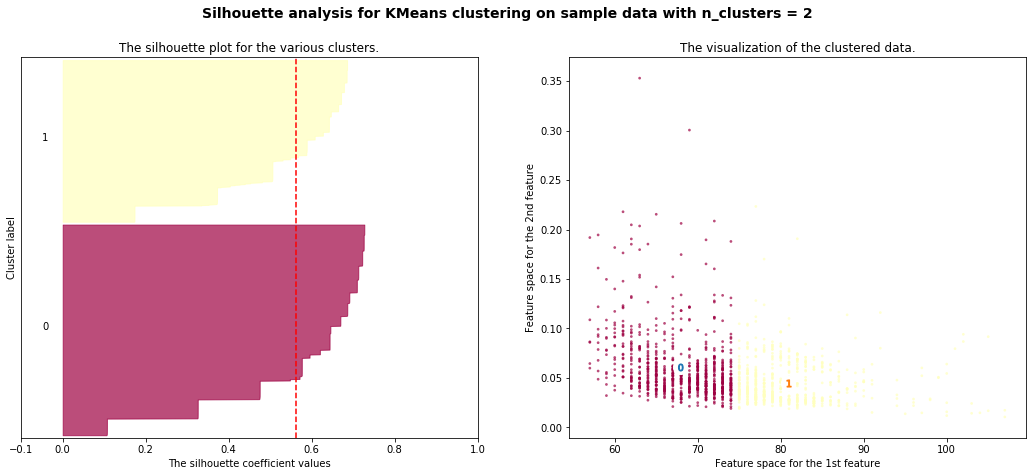

For n_clusters = 3 The average silhouette_score is : 0.5443602969860041


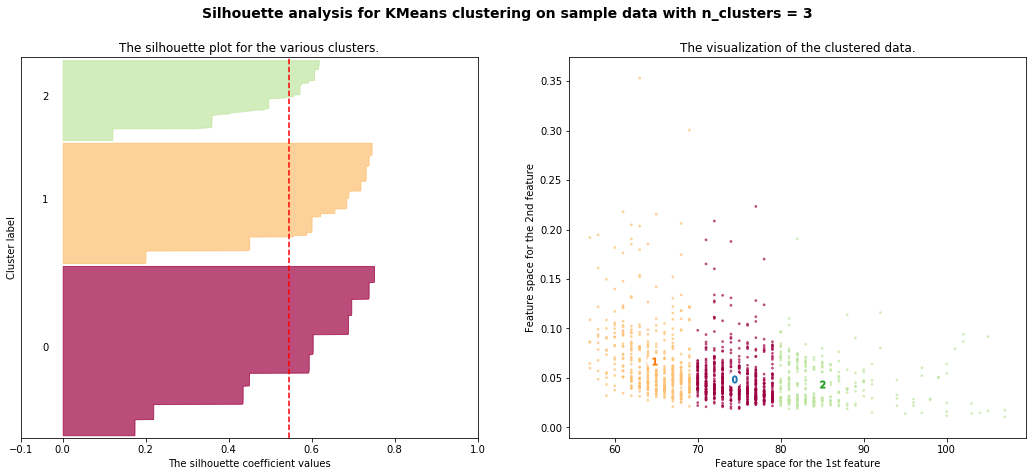

For n_clusters = 4 The average silhouette_score is : 0.5548072466437359


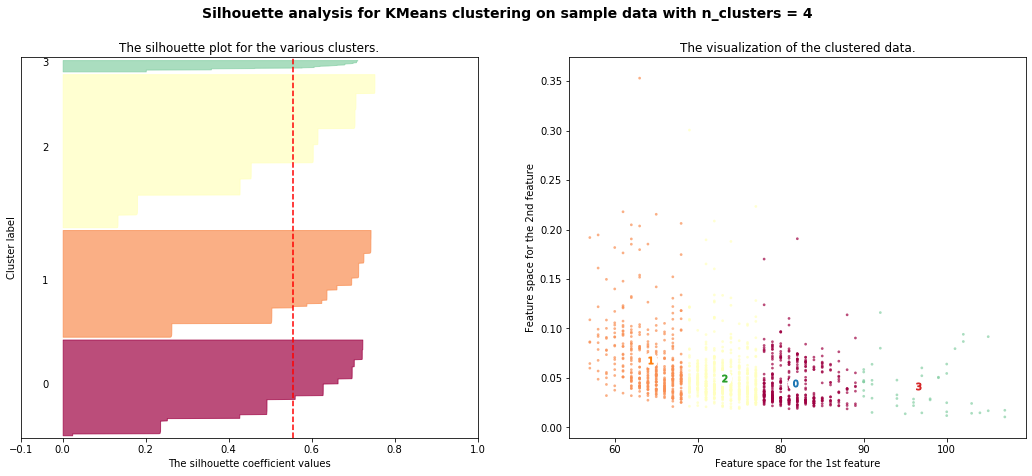

For n_clusters = 5 The average silhouette_score is : 0.5514302192204896


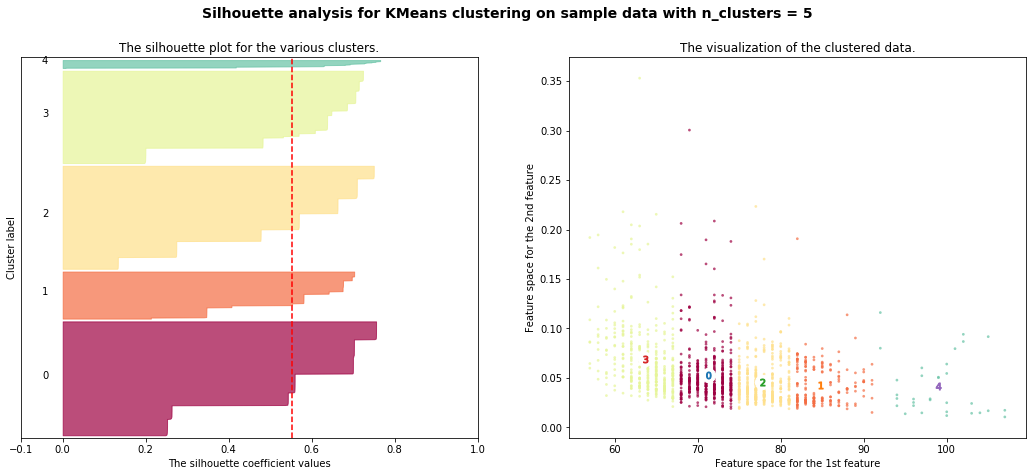

For n_clusters = 6 The average silhouette_score is : 0.540574077136454


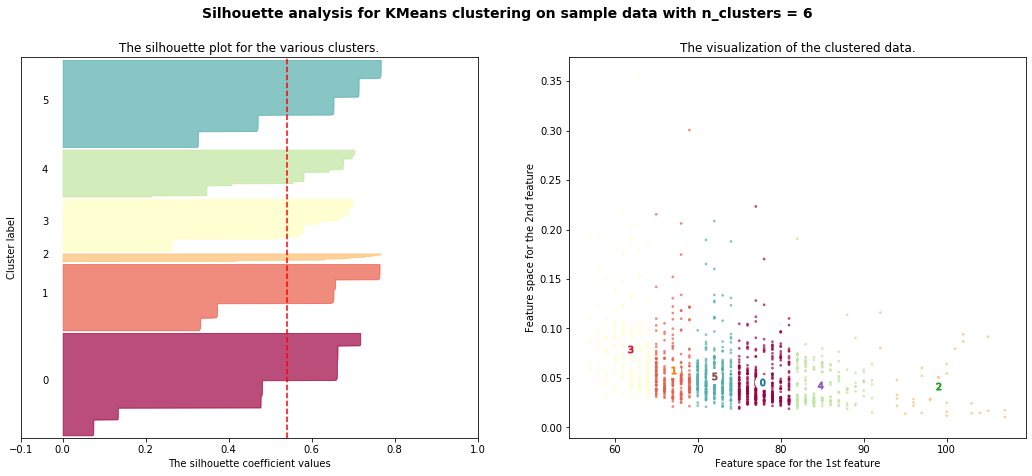

For n_clusters = 7 The average silhouette_score is : 0.550410763792057


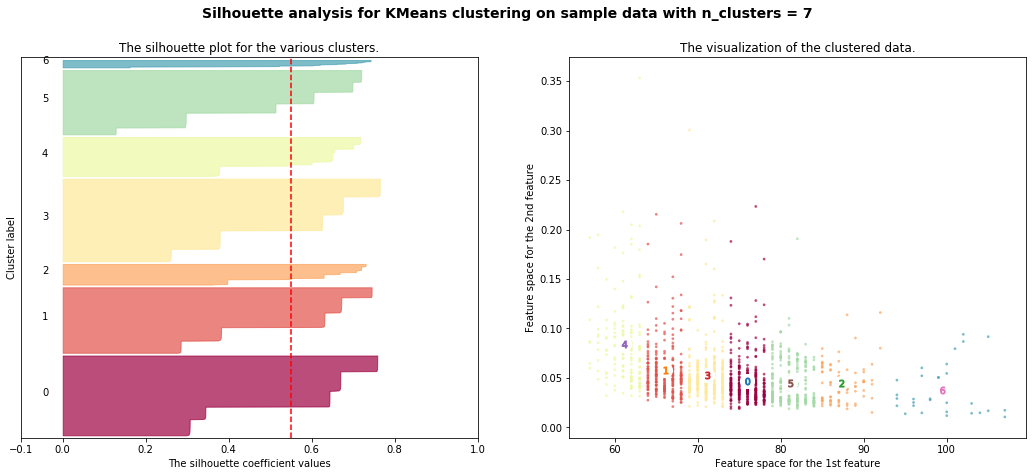

For n_clusters = 8 The average silhouette_score is : 0.5512424683847481


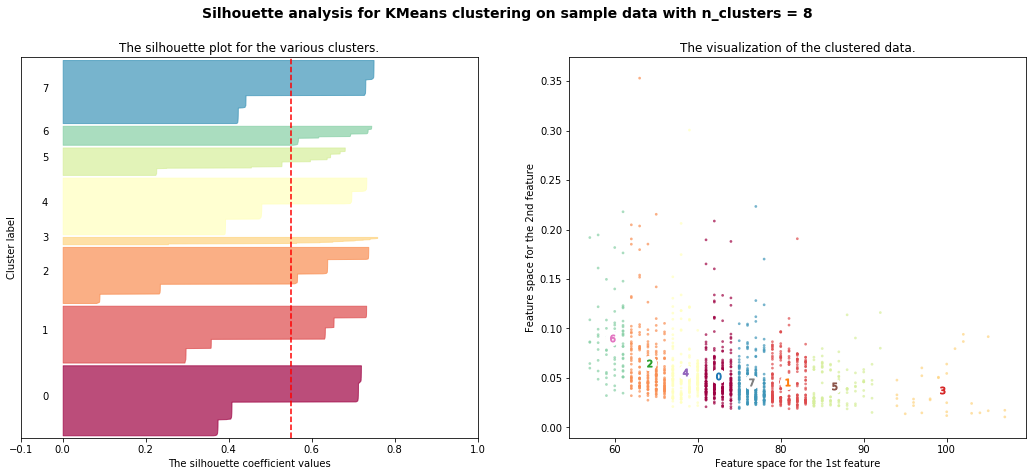

For n_clusters = 9 The average silhouette_score is : 0.5611435001773779


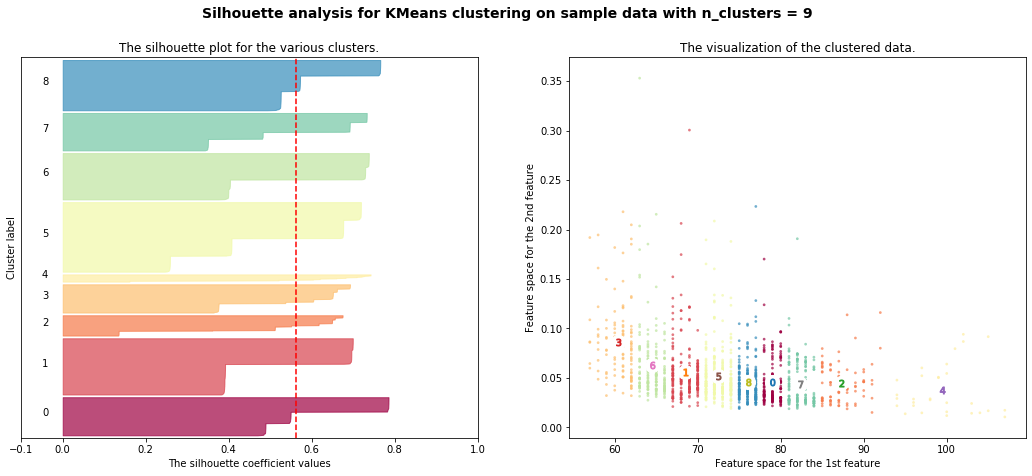

For n_clusters = 10 The average silhouette_score is : 0.5660439533200183


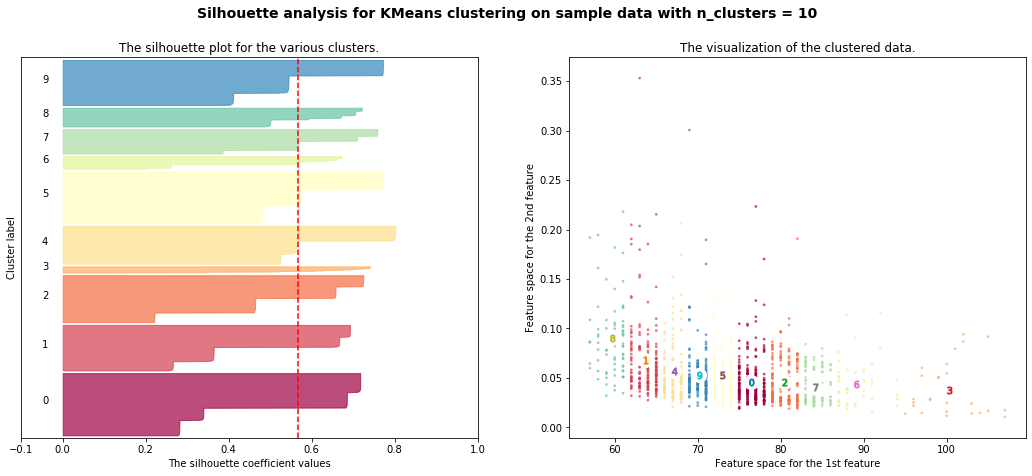

For n_clusters = 11 The average silhouette_score is : 0.5824060450020594


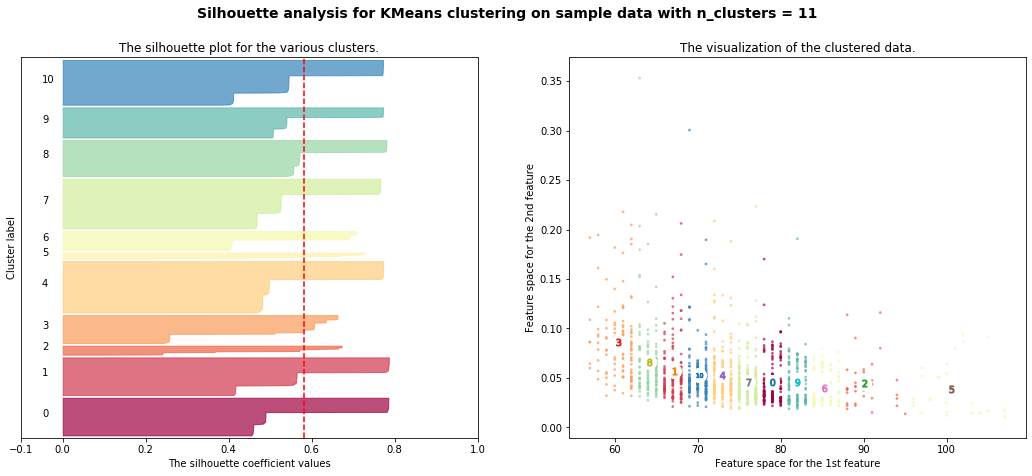

For n_clusters = 12 The average silhouette_score is : 0.5860902715470716


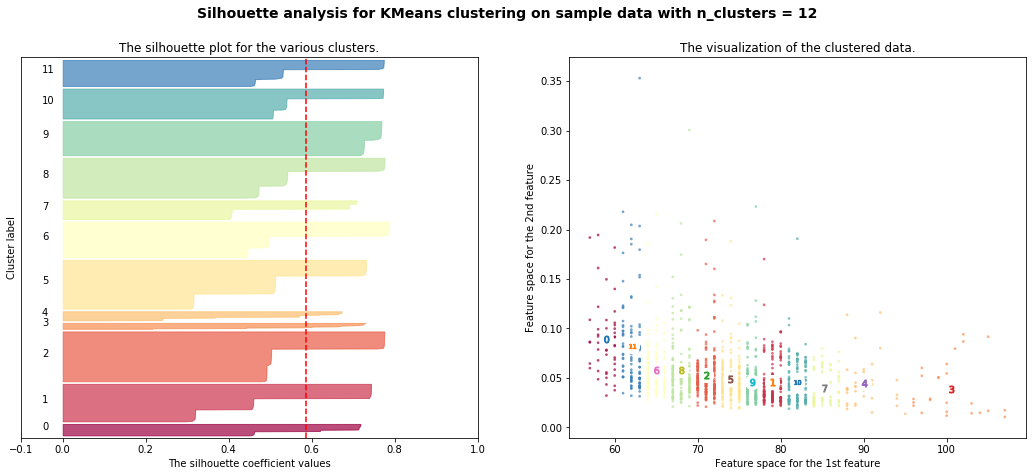

For n_clusters = 13 The average silhouette_score is : 0.5785828732329653


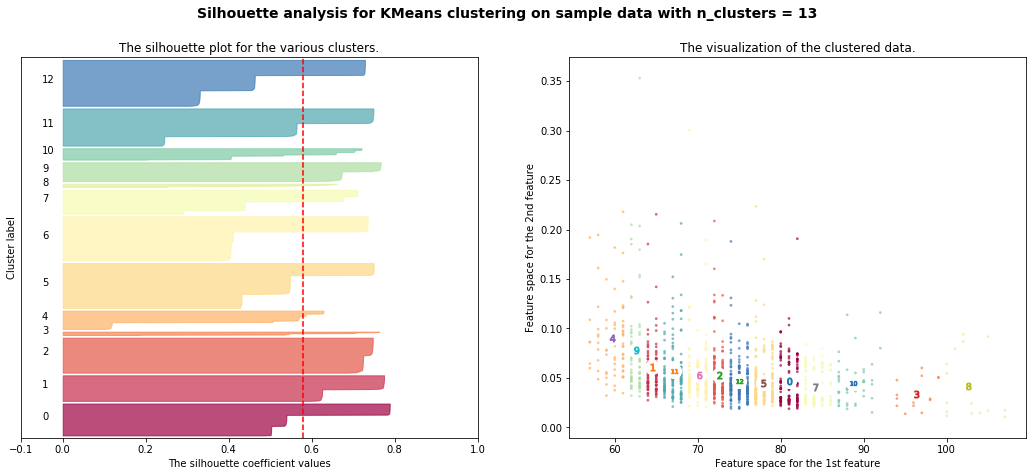

For n_clusters = 14 The average silhouette_score is : 0.5935839291866907


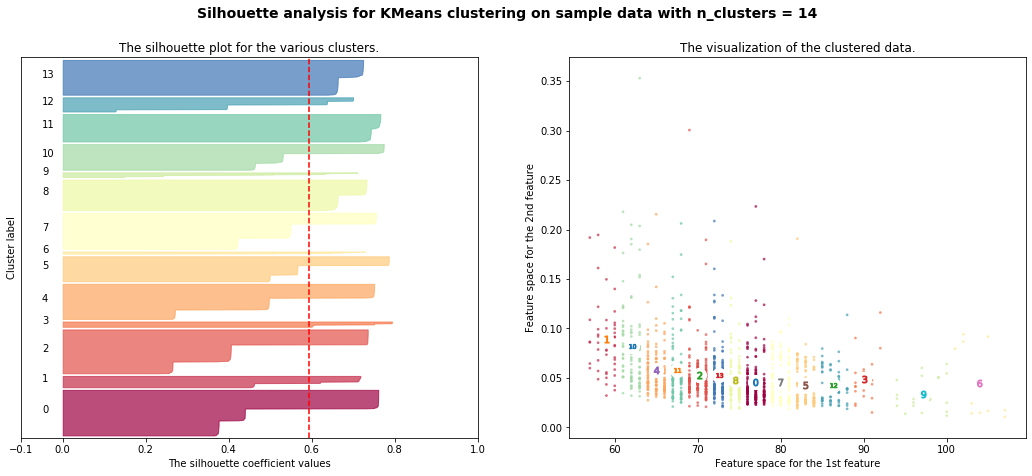

For n_clusters = 15 The average silhouette_score is : 0.6150873687072965


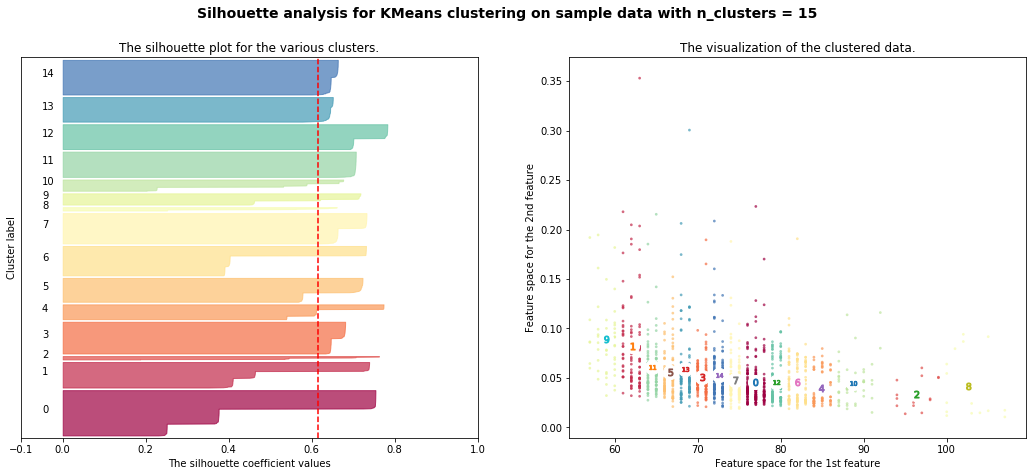

For n_clusters = 16 The average silhouette_score is : 0.6060077078471819


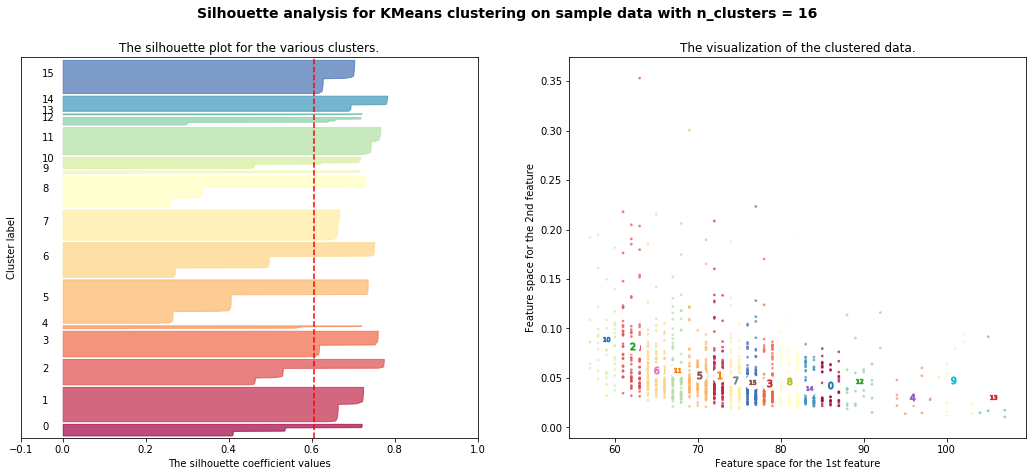

For n_clusters = 17 The average silhouette_score is : 0.6357201713579358


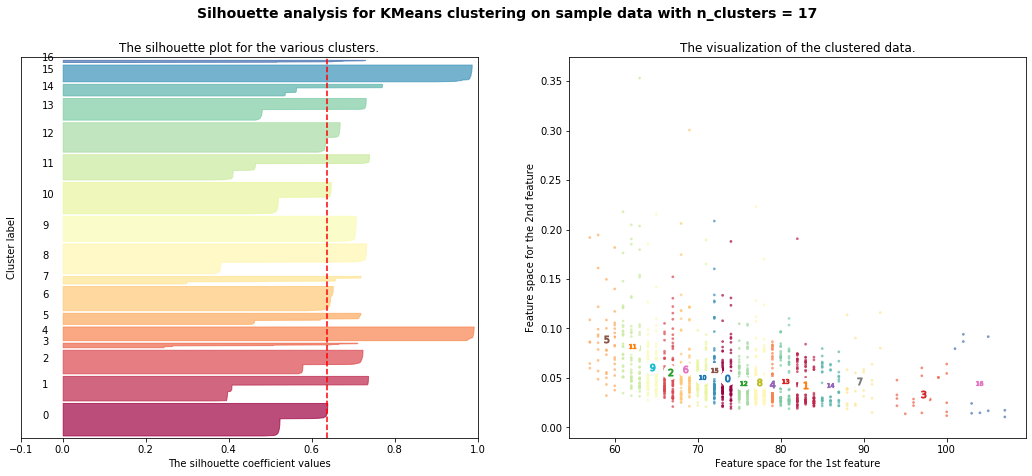

For n_clusters = 18 The average silhouette_score is : 0.6456983518779265


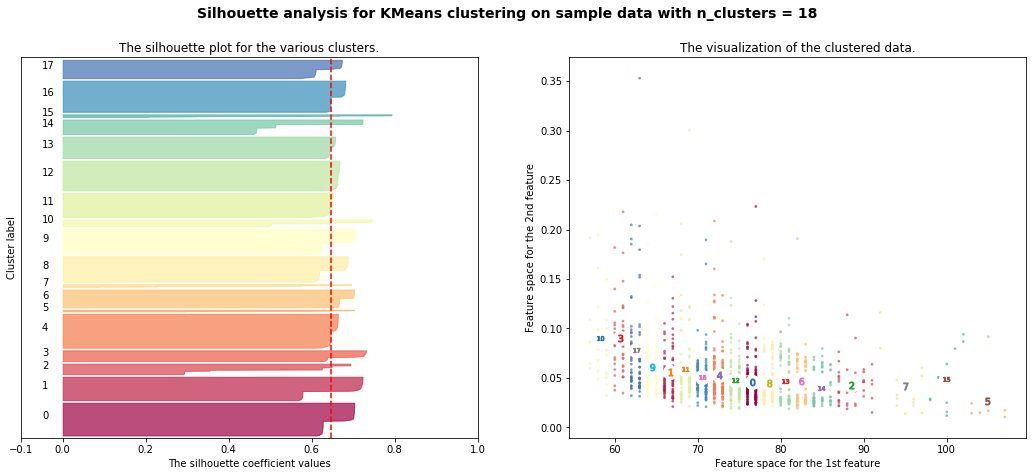

For n_clusters = 19 The average silhouette_score is : 0.6336808323692598


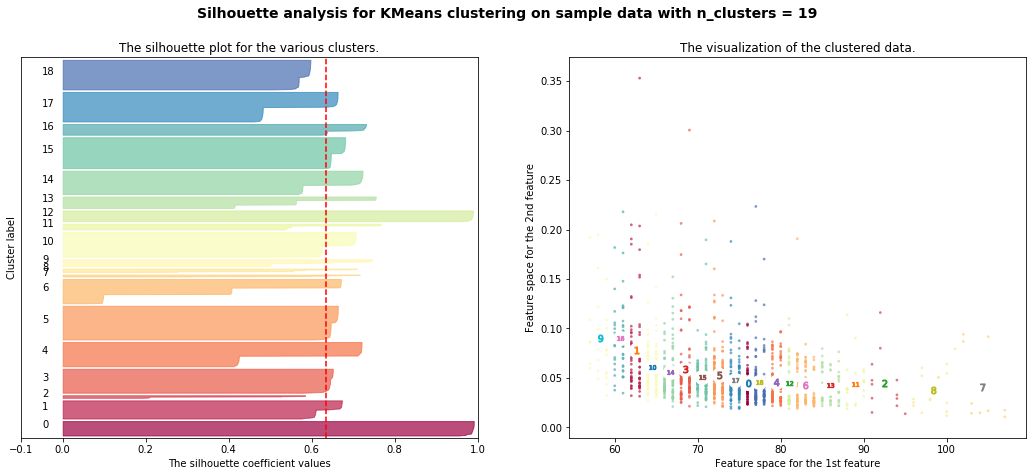

For n_clusters = 20 The average silhouette_score is : 0.6771677069552923


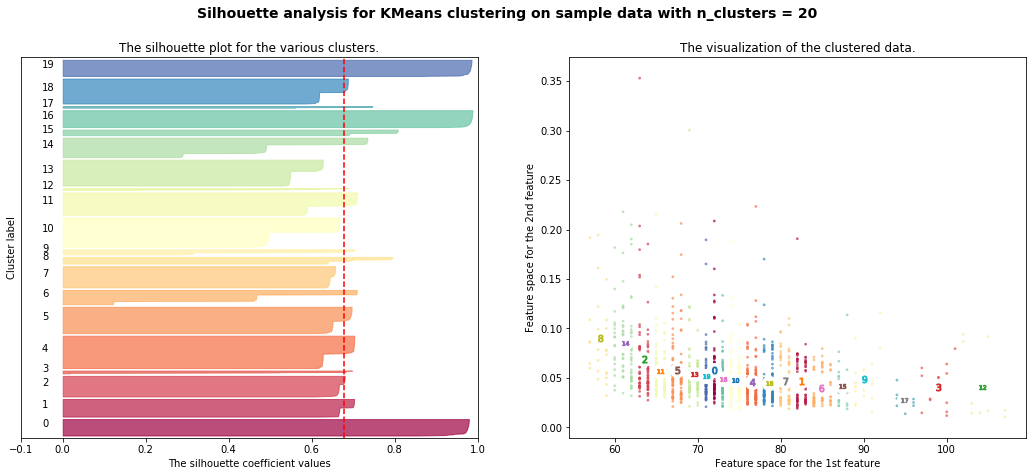

For n_clusters = 21 The average silhouette_score is : 0.6804441428774292


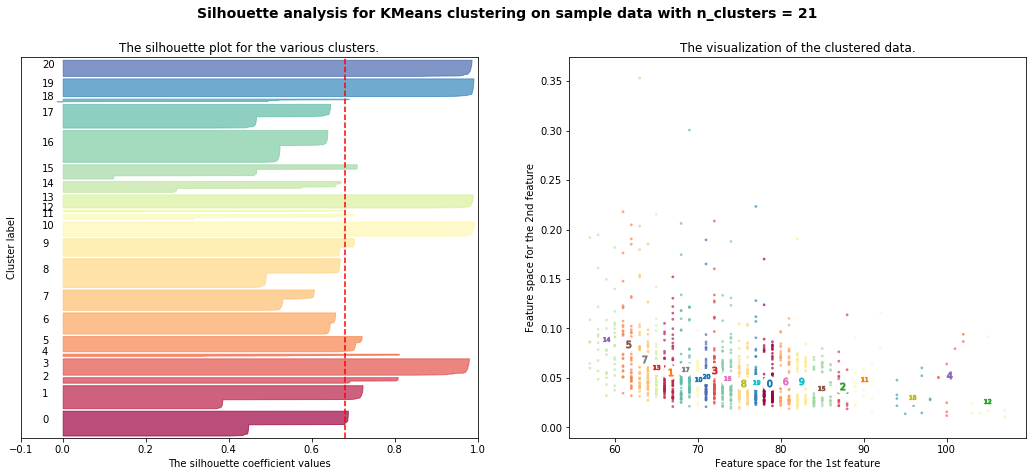

For n_clusters = 22 The average silhouette_score is : 0.6989750452128367


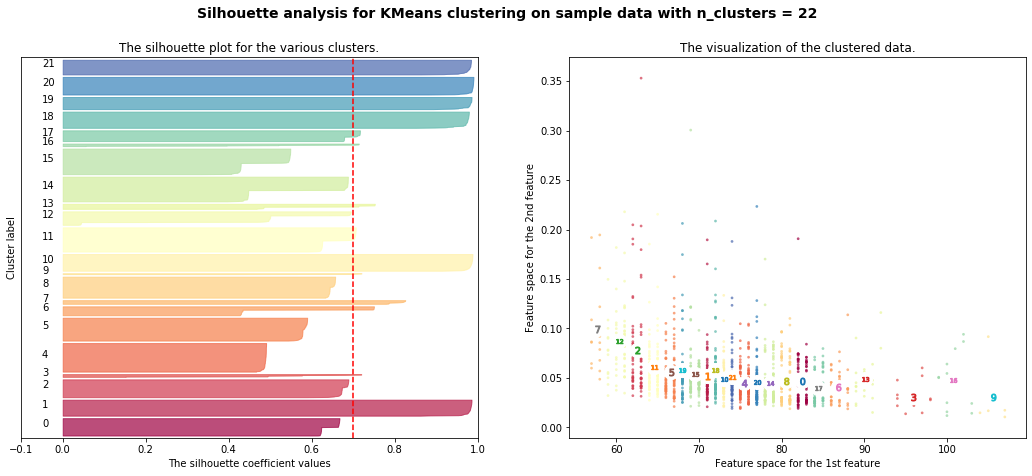

In [126]:
# --- From Clustering Lecture ---
X = df[['HR', 'RMSSD']]
range_n_clusters = range(2, 23)

# taken from sklearn
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
            "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        cmap = cm.get_cmap('Spectral')
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                            0, ith_cluster_silhouette_values,
                            facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhoutte score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed

    colors = cmap(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X.iloc[:, 0], X.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                    "with n_clusters = %d" % n_clusters),
                    fontsize=14, fontweight='bold')

    plt.savefig(f'Silhoutte for {n_clusters} clusters.png')
    plt.show()